<a href="https://colab.research.google.com/github/sammyfow/cap-comp215/blob/2024.01/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Langton's Ant
--------------------------------------------------------------------------------
###Sam Fowler
04/05/2024 to 04/12/2024


Modules

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from timeit import timeit
%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

Useful function for visualizing a 2D array, as well as the Animation2D class to easily view sequential steps as an animation.

In [2]:
def plot_2D_array(array, axes=None, title='', cmap='rainbow', **options):
  axes = axes or plt.gca()
  axes.set_title(title)
  axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
  options = {**dict(interpolation='nearest', origin='upper'), **options}
  axes.imshow(array, cmap=cmap, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
          for _ in range(self.steps_per_frame):
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

A grid class for ants to live on and an Ant class to walk around the grid.

In [4]:
class Grid:
  def __init__(self, size):
    self.size = size
    self.state = np.zeros((size, size), dtype=np.uint8)


class Ant:
  """
  an ant that moves around a 2D array changing ones to zeros and zeros to ones
  """
  def __init__(self, y, x, direction, grid):
    self.direction = direction  #up=0, down=2, right=1, left=3
    self.grid = grid
    self.x = x % self.grid.size
    self.y = y % self.grid.size

  def turn(self):
    if self.grid.state[self.y, self.x] == 0:
      self.direction = (self.direction + 1) % 4
    elif self.grid.state[self.y, self.x] == 1:
      self.direction = (self.direction - 1) % 4

  def move_forward(self):
    if self.direction == 0:
      self.y = (self.y - 1) % self.grid.size
    elif self.direction == 1:
      self.x = (self.x + 1) % self.grid.size
    elif self.direction == 2:
      self.y = (self.y + 1) % self.grid.size
    elif self.direction == 3:
      self.x = (self.x - 1) % self.grid.size

  def step(self):
    self.turn()
    self.grid.state[self.y, self.x] = (self.grid.state[self.y, self.x] + 1) % 2
    self.move_forward()










The Langton class below allows for an arbitrary number of ants to be simulated simultaneously on the same grid, adding more complexity to the original experiment.

In [5]:
class Langton:
  def __init__(self, ants:list):
    self.ants = ants

  def step(self):
    for ant in self.ants:
      ant.step()

  def nth_step(self, steps):
    for step in range(steps):
      self.step()

  def draw(self, axes=None, step=''):
    axes = axes or plt.gca()
    plot_2D_array(self.ants[0].grid.state, axes, title='')

Let's see what a plot of a single ant looks like

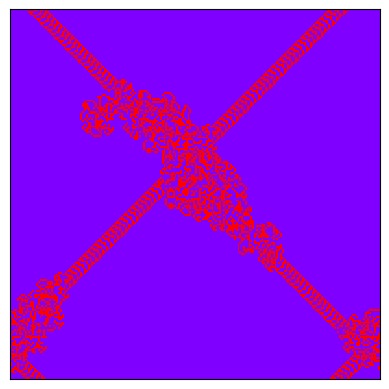

In [11]:
step = 50000
single = Langton([Ant(100, 100, 0, Grid(200))])
single.nth_step(step)
single.draw()

What about 4 ants

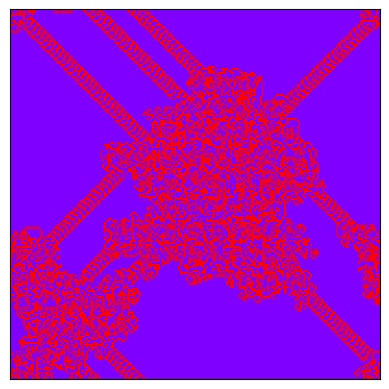

In [14]:
grid = Grid(200)
four_ants = [Ant(100, 100, 0, grid) for i in range(4)]
quadruple = Langton(four_ants)
quadruple.nth_step(step)
quadruple.draw()

The original Ant class only allows an ant to flip between 1s and 0s. The complex ant class below allows for an arbitrary number of possible states for each cell and a rule for each possible state.

In [18]:
class Complex_Ant:
  """
  an ant that allows for many states in each cell with a rule to turn right or
  left for each state.
  To replicate the original ant, rule would be RL
  """
  def __init__(self, y, x, direction, rule:str, grid):
    self.direction = direction  #up=0, down=2, right=1, left=3
    self.rule = rule
    self.shades = len(self.rule)
    self.grid = grid
    self.x = x % self.grid.size
    self.y = y % self.grid.size

  def turn(self):
    if self.rule[self.grid.state[self.y, self.x]] == 'R':
      self.direction = (self.direction + 1) % 4
    elif self.rule[self.grid.state[self.y, self.x]] == 'L':
      self.direction = (self.direction - 1) % 4

  def move_forward(self):
    if self.direction == 0:
      self.y = (self.y - 1) % self.grid.size
    elif self.direction == 1:
      self.x = (self.x + 1) % self.grid.size
    elif self.direction == 2:
      self.y = (self.y + 1) % self.grid.size
    elif self.direction == 3:
      self.x = (self.x - 1) % self.grid.size

  def step(self):
    self.turn()
    self.grid.state[self.y, self.x] = (self.grid.state[self.y, self.x] + 1) % self.shades
    self.move_forward()



Here are four stunning plots of known interesting rules

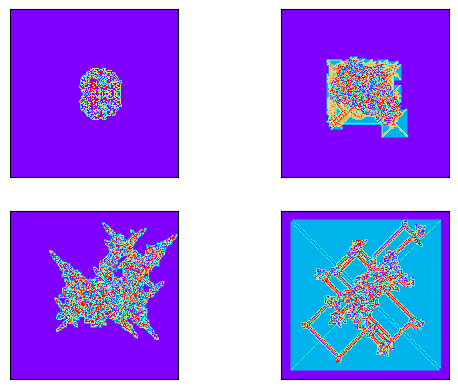

In [30]:
ant1 = Langton([Complex_Ant(100, 100, 0, 'RRLL', Grid(200))])
ant1.nth_step(200000)
ant2 = Langton([Complex_Ant(100, 100, 0, 'RLRRLLLLL', Grid(200))])
ant2.nth_step(200000)
ant3 = Langton([Complex_Ant(100, 100, 0, 'RRLLLRLRL', Grid(200))])
ant3.nth_step(200000)
ant4 = Langton([Complex_Ant(100, 100, 0, 'LRRRRRLLR', Grid(200))])
ant4.nth_step(200000)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ant1.draw(axes=ax1)
ant2.draw(axes=ax2)
ant3.draw(axes=ax3)
ant4.draw(axes=ax4)

Below is a graph of a timing test for ants on grids of different sizes, notice the grid size does not effect the time. Notice as well that the time grows linearly as the number of steps increases.

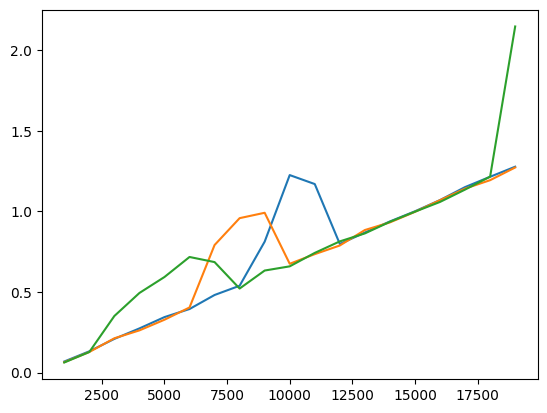

In [33]:
frames = range(1000, 20000, 1000)
hundred = Langton([Ant(50, 50, 0, Grid(100))])
five_hundred = Langton([Ant(50, 50, 0, Grid(500))])
thousand = Langton([Ant(50, 50, 0, Grid(1000))])
times1 = [timeit(lambda: hundred.nth_step(frame), number=10) for frame in frames]
times2 = [timeit(lambda: five_hundred.nth_step(frame), number=10) for frame in frames]
times3 = [timeit(lambda: thousand.nth_step(frame), number=10) for frame in frames]
plt.plot(frames, times1)
plt.plot(frames, times2)
plt.plot(frames, times3)
plt.show()





Below is a timing test for different numbers of ants on a grid. As we can see each still grows linearly, additional ants only steepen the growth.

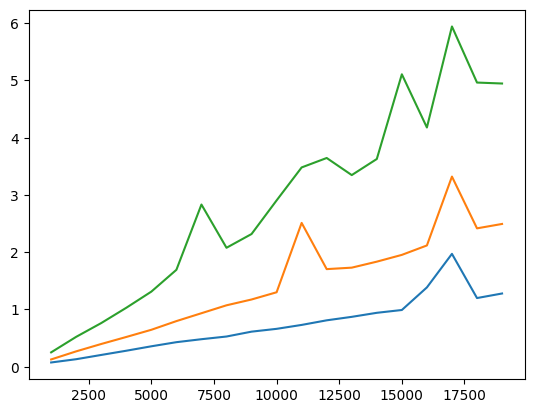

In [34]:
one = Langton([Ant(100, 100, 0, Grid(200))])
two = Langton([Ant(100, 100, 0, Grid(200)) for i in range(2)])
four = Langton([Ant(100, 100, 0, Grid(200)) for i in range(4)])
t1 = [timeit(lambda: one.nth_step(frame), number=10) for frame in frames]
t2 = [timeit(lambda: two.nth_step(frame), number=10) for frame in frames]
t3 = [timeit(lambda: four.nth_step(frame), number=10) for frame in frames]
plt.plot(frames, t1)
plt.plot(frames, t2)
plt.plot(frames, t3)
plt.show()